In [1]:
import torch
from torch.autograd.functional import hessian
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from models import LS, CG, CG_naive, freq_std

$P(\bm{X}) = \mathrm{const} -\frac{1}{2} (X - \mu)^T \Sigma^{-1} (X - \mu)$ not just degenerate - see Hessian + errorbars. Maximum just in the wrong place.
- $P(X)$ posterior has much larger variance than $P(\theta|D)$. Regularisation term reduces degeneracy. 

Why does using $P(X)$ work for linear likelihood, but not $-X^{2/d}$? 
- Linear has sharper peak, so less affected by regularization term. Can see by width of posterior for linear vs simple models. Value at peak irrelevant (can shift up and down with normalisation), just how sharply the decline is on both sides. Slower decline $\implies$ greater shift when applying regularisation, which is the case for Gaussian likelihoods.

**Interpretation of $L^{-1}$:**
- Subtract off loss of previous point, and normalise by mean at present point. This removes the correlations; instead minimise the Gaussian noise at each step when we simulate a new $t$. 
- Problem - noise in $t$ is not Gaussian. Generated $t$ from Gaussian distribution with same mean/variance and modelled again.
- **When $t$ is Gaussian, $\sigma_H = \sigma_\text{freq}$!** The wrong assumption about $t$ drives the true error higher than expected, which causes CG to be on par with LS. 
- Try again with $\log X$ simulated directly from its mean/covariance. Expect this to give the same conclusion - **it does**

Higher $n_\text{live}$ improves parameter estimates. Posterior peak sharper/less degenerate due to lower noise in X. 

**Wedding cake doesn't work because the correlations have been wiped by the floor function**. Applying $L^{-1}$ subtraction process gives zeros, since all y values are the same. Other functions reduce correlations too? Perhaps if y not very sensitive to X. 

### **Generate Gaussian $\log t$**
Minimise $P(\log X)$, which assumes Gaussian errors in $t$

- Get $\sigma_H$ out of this and compare to $\sigma_\text{freq}$

In [2]:
def logtgaussian_sample(n):
    return np.random.normal(-1/n, 1/n)
logtgaussian_sample = np.vectorize(logtgaussian_sample)

def generate_logXs_gaussian(nk):
    logt_samples = logtgaussian_sample(nk)
    logXs = np.cumsum(logt_samples)
    return logXs

In [3]:
def simple_loglike():
    def func(logx, theta):
        x = np.exp(logx)
        return -x**(2/theta)
    def inverse(y, theta, torched=False):
        x = (-y)**(theta/2)
        if torched:
            return torch.log(x)
        return np.log(x)
    def prime(logx, theta, torched=False):
        x = torch.exp(logx) if torched else np.exp(logx)
        return -2/theta * x**(2/theta)
    return likelihood(func, inverse, prime)
simple_log = simple_loglike()

In [153]:
def logPr_logX(y, likelihood, mean, covinv, theta):
    logXstar = likelihood.inverse(y, theta)
    log_abs_fprimes = np.log(abs(likelihood.prime(logXstar, theta)))
    return - 0.5 * (logXstar - mean).T @ covinv @ (logXstar - mean) -np.sum(log_abs_fprimes)

def minimise_logX(y, likelihood, mean, covinv, x0):
    def func(theta):
        return - logPr_logX(y, likelihood, mean, covinv, theta)
    from scipy.optimize import minimize
    solution = minimize(func, x0)
    return solution.x

def hess(y, likelihood, mean, covinv, theta_max):
    y = torch.from_numpy(y)
    mean = torch.from_numpy(mean)
    covinv = torch.from_numpy(covinv)
    theta_max = torch.tensor(theta_max, requires_grad=True)
    def func(theta):
        logXstar = likelihood.inverse(y, theta, torched=True)
        log_abs_fprimes = torch.log(abs(likelihood.prime(logXstar, theta, torched=True)))
        return - torch.sum(log_abs_fprimes) - 1/2 * (logXstar - mean).T @ covinv @ (logXstar - mean)
    H = hessian(func, theta_max)
    return np.array(H)

In [5]:
nk = nk_dead_live(nlive=500, ndead=500)
mean_logX = logX_mu(nk)
covinv_logX = logX_Sigmainv(nk)
cov_logX = np.linalg.inv(covinv_logX)

##### Simulate $t$ from Gaussian distribution

In [6]:
logX = generate_logXs_gaussian(nk)
theta_true = 10
y = simple_log.func(logX, theta_true)

In [7]:
theta_g = minimise_logX(y, simple_log, mean_logX, covinv_logX, 10)
H = hess(y, simple_log, mean_logX, covinv_logX, theta_g)
np.sqrt(-1/H)

array([[0.18035117]])

In [9]:
results = []
for i in range(50):
    logX = generate_logXs_gaussian(nk)
    # logX = np.log(generate_Xs(nk))
    theta_true = 10
    y = simple_log.func(logX, theta_true)
    results.append(minimise_logX(y, simple_log, mean_logX, covinv_logX, theta_true))
np.std(results)

0.17539975066333888

##### Now generate $\log X$ directly from its mean and covariance to compare. Get same conclusion

In [10]:
nk = nk_dead_live(nlive=500, ndead=500)
mean_logX = logX_mu(nk)
covinv_logX = logX_Sigmainv(nk)
cov_logX = np.linalg.inv(covinv_logX)

In [11]:
logX = np.random.multivariate_normal(mean_logX, cov_logX)

In [12]:
theta_true = 10
y = simple_log.func(logX, theta_true)

In [16]:
theta_g = minimise_logX(y, simple_log, mean_logX, covinv_logX, 10)
H = hess(y, simple_log, mean_logX, covinv_logX, theta_g)
np.sqrt(-1/H)

array([[0.18387095]])

In [18]:
results = []
for i in range(10):
    logX = np.random.multivariate_normal(mean_logX, cov_logX)
    # logX = np.log(generate_Xs(nk))
    theta_true = 10
    y = simple_log.func(logX, theta_true)
    results.append(minimise_logX(y, simple_log, mean_logX, covinv_logX, theta_true))
np.std(results)

0.16293130320992175

### **Comparing before/after regularisation term**

In [19]:
nk = nk_dead_live(nlive=500, ndead=1000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

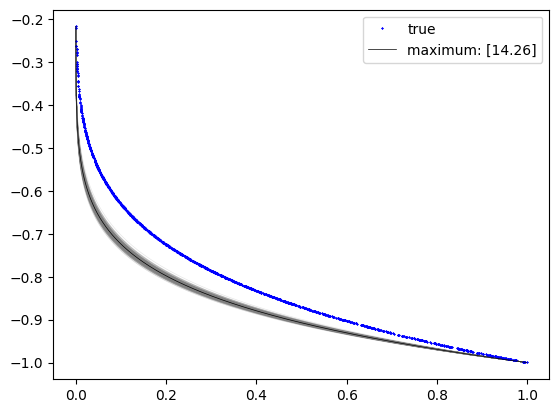

In [20]:
like = simple
X = generate_Xs(nk)
theta_true = 10
y = like.func(X, theta_true)
cgn = CG_naive(y, like, mean_X, covinv_X)
theta_cn = cgn.minimise(theta_true)
covcn = cgn.covtheta(theta_cn)

for i in range(200):
    theta, = np.random.normal(theta_cn, np.sqrt(covcn))
    Xcn = like.inverse(y, theta)
    plt.plot(Xcn, y, lw=.5, color='gray', alpha=.2)
plt.plot(X, y, 'x', ms=1, color='blue', label='true')
plt.plot(like.inverse(y, theta_cn), y, lw=.5, color='black', label=f'maximum: {np.round(theta_cn, 2)}')
plt.legend();
# plt.xlim(0.2, 0.22);
# plt.ylim(2, 2.2);

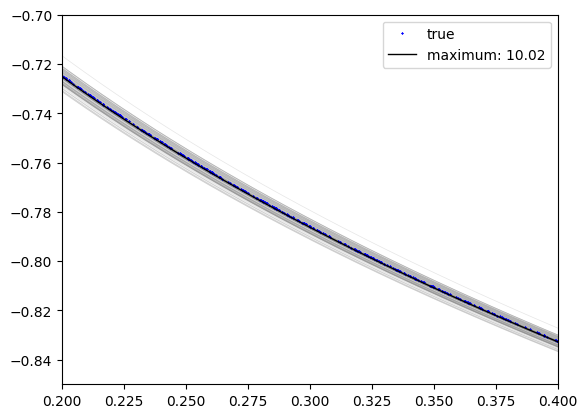

In [21]:
like = simple
X = generate_Xs(nk)
theta_true = 10
y = like.func(X, theta_true)
cg = CG(y, like, mean_X, covinv_X)
theta_c = cg.minimise(theta_true)
covc = cg.covtheta(theta_c)
cg.plot_errors(X, theta_c)
plt.xlim(0.2, 0.4)
plt.ylim(-0.85, -0.7);

$P(X)$ posterior has larger variance than $P(\theta|D)$. Regularisation term reduces degeneracy. 

In [22]:
np.sqrt(covc), np.sqrt(covcn)

(array([[0.11504538]]), array([[0.36663665]]))

In [23]:
def simple_step(X, theta, steps=10):
    return -np.floor(X**(2/theta) * steps)/steps
nlive, ndead = 500, 500
nk = nk_dead_live(nlive, ndead)
mean = X_mu(nk)
covinv = X_Sigmainv(nk)

In [24]:
X = generate_Xs(nk)
y = simple_step(X, 10, steps=10)
like = middle
ls = LS(y, like, mean, covinv)
cg = CG(y, like, mean, covinv)

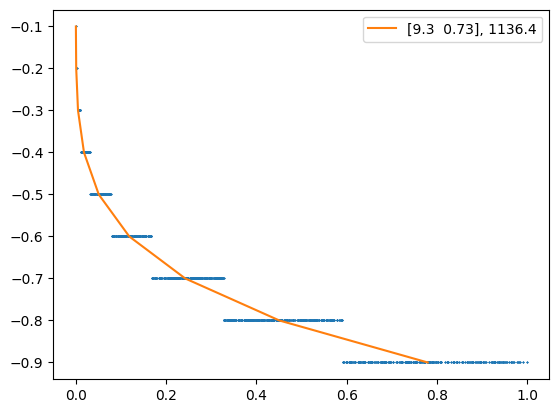

In [25]:
theta_l = ls.minimise([10, 0.1])
plt.plot(X, y, 'x', ms=1)
plt.plot(like.inverse(y, theta_l), y, label=f'{np.round(theta_l, 2)}, {ls.logZ(theta_l):.1f}')
plt.legend();

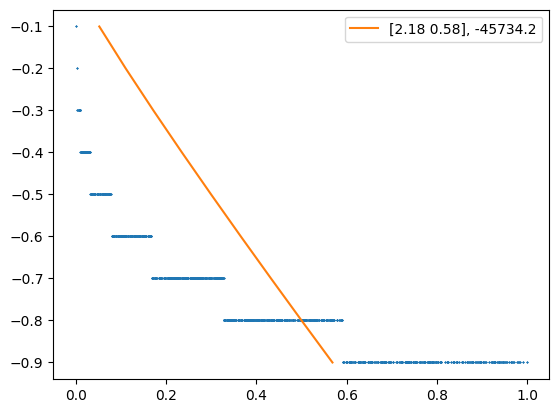

In [26]:
theta_c = cg.minimise([6, 0.7])
plt.plot(X, y, 'x', ms=1)
plt.plot(like.inverse(y, theta_c), y, label=f'{np.round(theta_c, 2)}, {cg.logZ(theta_c):.1f}')
plt.legend();

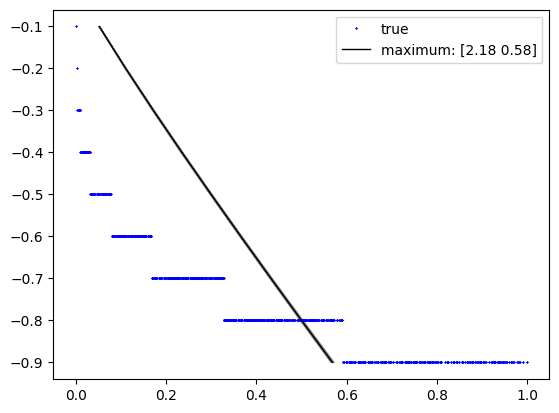

In [28]:
cg.plot_errors(X, theta_c, lines=200)
# plt.xlim(0.2, 0.3)
# plt.ylim(-0.6, -0.4)

### **How well does CG do least squares on $t$?**

In [179]:
nk = nk_dead(nlive=500, ndead=1000)
mean_logX = logX_mu(nk)
covinv_logX = logX_Sigmainv(nk)
cov_logX = np.linalg.inv(covinv_logX)

In [183]:
Linv = np.linalg.cholesky(covinv_logX)
Linv @ Linv.T

array([[ 500000., -250000.,       0., ...,       0.,       0.,       0.],
       [-250000.,  500000., -250000., ...,       0.,       0.,       0.],
       [      0., -250000.,  500000., ...,       0.,       0.,       0.],
       ...,
       [      0.,       0.,       0., ...,  500000., -250000.,       0.],
       [      0.,       0.,       0., ..., -250000.,  500000., -250000.],
       [      0.,       0.,       0., ...,       0., -250000.,  250000.]])

In [187]:
Linv

array([[ 707.10678119,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [-353.55339059,  612.3724357 ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        , -408.24829046,  577.35026919, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,  500.25043828,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ..., -499.74968709,
         500.25018766,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        -499.74993747,   15.8113883 ]])

In [186]:
np.linalg.inv(np.linalg.cholesky(cov_logX))

array([[ 5.00000000e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.00000000e+02,  5.00000000e+02,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.55111512e-14, -5.00000000e+02,  5.00000000e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.18163795e-25, -2.22044605e-13,  4.44089210e-13, ...,
         5.00000000e+02,  0.00000000e+00,  0.00000000e+00],
       [-1.41799674e-25,  8.40969796e-25, -2.22044605e-13, ...,
        -5.00000000e+02,  5.00000000e+02, -3.67067486e-15],
       [-8.68423960e-26,  4.44089210e-13, -6.66133815e-13, ...,
         2.16882068e-10, -5.00000000e+02,  5.00000000e+02]])

In [114]:
logX = np.exp(generate_Xs(nk))
logX_gauss = generate_logXs_gaussian(nk)
theta_true = 10
y = simple_log.func(logX_gauss, theta_true)

In [169]:
def logPr_logX(y, likelihood, mean, covinv, theta):
    logXstar = likelihood.inverse(y, theta)
    log_abs_fprimes = np.log(abs(likelihood.prime(logXstar, theta)))
    return - 0.5 * (logXstar - mean).T @ covinv @ (logXstar - mean) #- np.sum(log_abs_fprimes)

def minimise_logX(y, likelihood, mean, covinv, x0):
    def func(theta):
        return - logPr_logX(y, likelihood, mean, covinv, theta)
    from scipy.optimize import minimize
    solution = minimize(func, x0)
    return solution.x

This is confusing

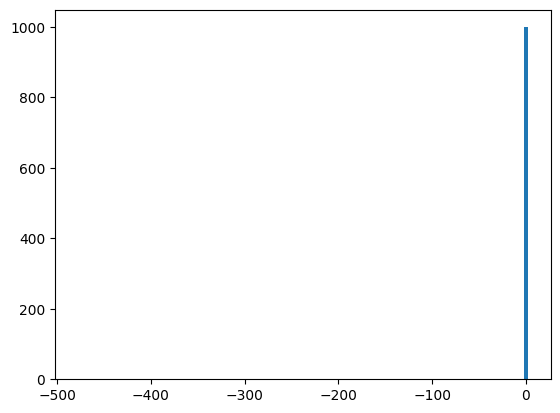

In [177]:
logX_gauss = generate_logXs_gaussian(nk)
theta_true = 10
y = simple_log.func(logX_gauss, theta_true)
theta_g = minimise_logX(y, simple_log, mean_logX, covinv_logX, 10)
logXs_g = simple_log.inverse(y, theta_g)
Linv = np.linalg.cholesky(covinv_logX)
errors = Linv @ (logXs_g - mean_logX)
plt.hist(errors, bins=100);

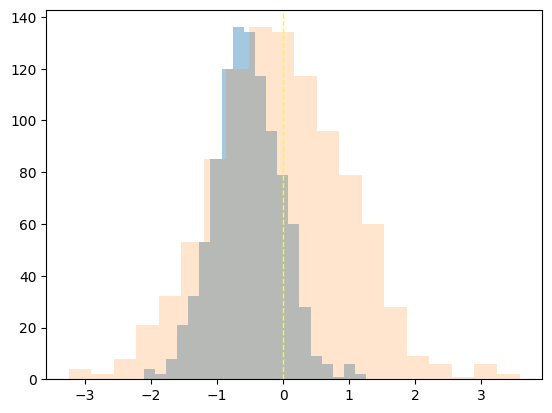

In [175]:
logX_gauss = generate_logXs_gaussian(nk)
theta_true = 10
y = simple_log.func(logX_gauss, theta_true)
theta_g = minimise_logX(y, simple_log, mean_logX, covinv_logX, 10)
logXs_g = simple_log.inverse(y, theta_g)
errors = (logXs_g[1:] - logXs_g[:-1])/(-1/nk[:-1]) - 1
errors_true = (logX_gauss[1:] - logX_gauss[:-1])/(-1/nk[1:]) - 1

plt.hist(errors, bins=20, alpha=0.4);
plt.hist(errors_true, bins=20, alpha=0.2);
plt.axvline(x=0, lw=1, ls='--', color='yellow')

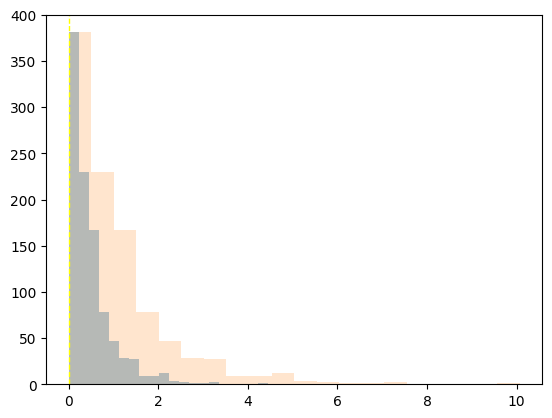

In [163]:
logX = np.log(generate_Xs(nk))
theta_true = 10
y = simple_log.func(logX, theta_true)
theta_g = minimise_logX(y, simple_log, mean_logX, covinv_logX, 10)
logXs_g = simple_log.inverse(y, theta_g)
logts_g = logXs_g[1:] - logXs_g[:-1]
errors = logts_g/(-1/nk[:-1])
errors_true = (logX[1:] - logX[:-1])/(-1/nk[1:])

plt.hist(errors, bins=20, alpha=0.4);
plt.hist(errors_true, bins=20, alpha=0.2);
plt.axvline(x=0, lw=1, ls='--', color='yellow')